<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-3-public/blob/main/Course%201%20-%20Custom%20Models%2C%20Layers%20and%20Loss%20Functions/Week%204%20-%20Models/C1_W4_Lab_2_resnet-example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Implementing ResNet

In this lab, you will continue exploring Model subclassing by building a more complex architecture. 

[Residual Networks](https://arxiv.org/abs/1512.03385) make use of skip connections to make deep models easier to train. 
- There are branches as well as many repeating blocks of layers in this type of network. 
- You can define a model class to help organize this more complex code, and to make it easier to re-use your code when building the model.
- As before, you will inherit from the [Model class](https://keras.io/api/models/model/) so that you can make use of the other built-in methods that Keras provides.

## Imports

In [1]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
from tensorflow.keras.layers import Input
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Layer
from tensorflow.keras.utils import plot_model

## Implement Model subclasses

As shown in the lectures, you will first implement the Identity Block which contains the skip connections (i.e. the `add()` operation below. This will also inherit the Model class and implement the `__init__()` and `call()` methods.

In [111]:
class IdentityBlock(tf.keras.Model):
    def __init__(self, filters=64, kernel_size=3):
        super(IdentityBlock, self).__init__(name='')

        self.conv1 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()

        self.conv2 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()

        self.act = tf.keras.layers.Activation('relu')
        self.add = tf.keras.layers.Add()
        self.act2 = tf.keras.layers.Activation('relu')
    
    def call(self, input_tensor):
        x = self.conv1(input_tensor)
        x = self.bn1(x)
        x = self.act(x)

        x = self.conv2(x)
        x = self.bn2(x)

        x = self.add([x, input_tensor])
        
        return self.act2(x)
    
    def build_graph(self, raw_shape):
        x = tf.keras.layers.Input(shape=raw_shape)
        return tf.keras.Model(inputs=[x], outputs=self.call(x))

In [112]:
raw_shape = (9,9,64)
block1 = IdentityBlock()
block1.build_graph(raw_shape).summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_53 (InputLayer)           [(None, 9, 9, 64)]   0                                            
__________________________________________________________________________________________________
conv2d_87 (Conv2D)              (None, 9, 9, 64)     36928       input_53[0][0]                   
__________________________________________________________________________________________________
batch_normalization_77 (BatchNo (None, 9, 9, 64)     256         conv2d_87[0][0]                  
__________________________________________________________________________________________________
activation_45 (Activation)      (None, 9, 9, 64)     0           batch_normalization_77[0][0]     
____________________________________________________________________________________________

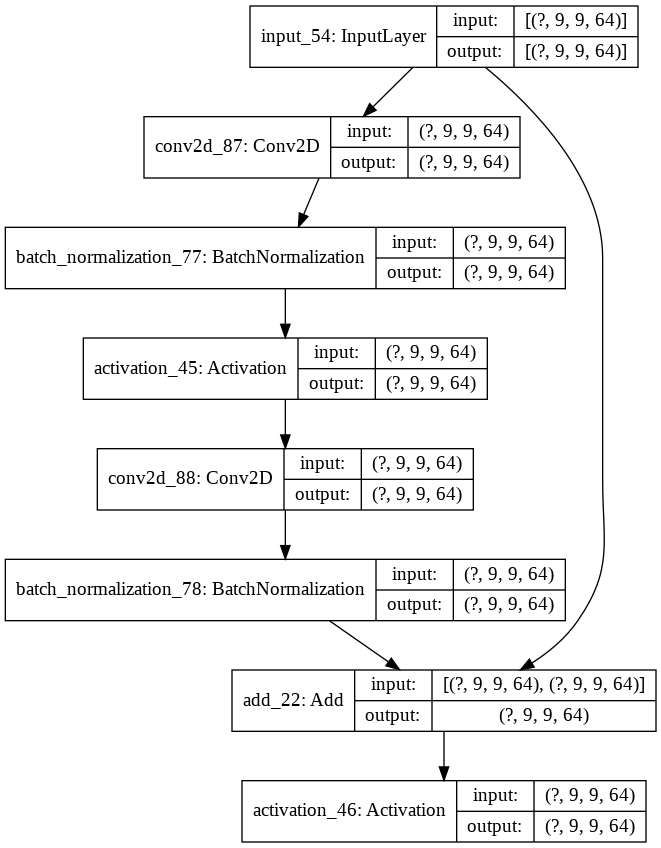

In [113]:
tf.keras.utils.plot_model(block1.build_graph(raw_shape),show_shapes=True)

In [114]:
filters=64
kernel_size=3
raw_shape = (28,28,1)
inputs = tf.keras.layers.Input(shape=raw_shape)
x=tf.keras.layers.Conv2D(64, 7, padding='same')(inputs) #28,28,64
x=tf.keras.layers.BatchNormalization()(x) #28,28,64
x=tf.keras.layers.Activation('relu')(x) #28,28,64
x=tf.keras.layers.MaxPool2D((3, 3))(x) #9,9,64

x1=tf.keras.layers.Conv2D(filters, kernel_size, padding='same')(x) #9,9,64
x1=tf.keras.layers.BatchNormalization()(x) #9,9,64
x1=tf.keras.layers.Activation('relu')(x) #9,9,64


x1=tf.keras.layers.Conv2D(filters, kernel_size, padding='same')(x)#9,9,64
x1=tf.keras.layers.BatchNormalization()(x)#9,9,64
x1.shape

TensorShape([None, 9, 9, 64])

In [116]:
added= tf.keras.layers.add([x,x1])
added.shape

TensorShape([None, 9, 9, 64])

From there, you can build the rest of the ResNet model. 
- You will call your `IdentityBlock` class two times below and that takes care of inserting those blocks of layers into this network.

In [121]:
class ResNet(tf.keras.Model):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        self.conv = tf.keras.layers.Conv2D(64, 7, padding='same')
        self.bn = tf.keras.layers.BatchNormalization()
        self.act = tf.keras.layers.Activation('relu')
        self.max_pool = tf.keras.layers.MaxPool2D((3, 3))

        # Use the Identity blocks that you just defined
        self.id1a = IdentityBlock(64, 3)
        self.id1b = IdentityBlock(64, 3)

        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.classifier = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.act(x)
        x = self.max_pool(x)

        # insert the identity blocks in the middle of the network
        x = self.id1a(x)
        x = self.id1b(x)

        x = self.global_pool(x)
        return self.classifier(x)
    def build_graph(self, raw_shape):
        x = tf.keras.layers.Input(shape=raw_shape)
        return tf.keras.Model(inputs=[x], outputs=self.call(x))

In [122]:
raw_input = (28,28,1)
block2 = ResNet()
block2.build_graph(raw_input).summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_56 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 28, 28, 64)        3200      
_________________________________________________________________
batch_normalization_87 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
activation_54 (Activation)   (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 9, 9, 64)          0         
_________________________________________________________________
identity_block_16 (IdentityB (None, 9, 9, 64)          74368     
_________________________________________________________________
identity_block_17 (IdentityB (None, 9, 9, 64)          7436

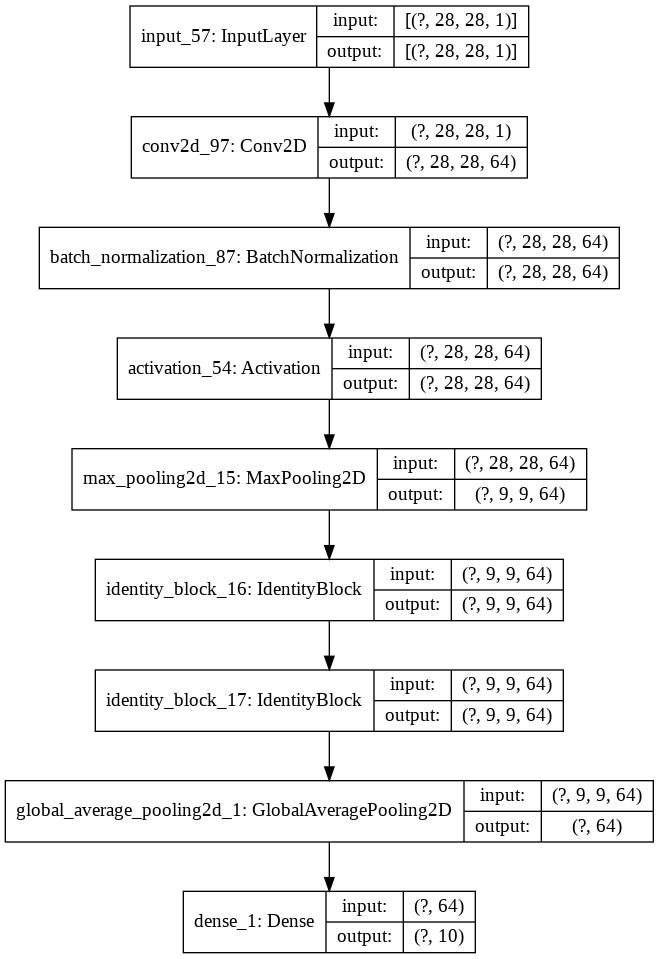

In [123]:
tf.keras.utils.plot_model(block2.build_graph(raw_input),show_shapes=True)

## Training the Model

As mentioned before, inheriting the Model class allows you to make use of the other APIs that Keras provides, such as:
- training
- serialization
- evaluation

You can instantiate a Resnet object and train it as usual like below:

**Note**: If you have issues with training in the Coursera lab environment, you can also run this in Colab using the "open in colab" badge link.

In [124]:
# utility function to normalize the images and return (image, label) pairs.
def preprocess(features):
    return tf.cast(features['image'], tf.float32) / 255., features['label']

# create a ResNet instance with 10 output units for MNIST
resnet = ResNet(10)
resnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# load and preprocess the dataset
dataset = tfds.load('mnist', split=tfds.Split.TRAIN, data_dir='./data')
dataset = dataset.map(preprocess).batch(32)

# train the model.
resnet.fit(dataset, epochs=1)

1875/1875 [==============================] - 259s 138ms/step - loss: 0.1296 - accuracy: 0.9653


In [77]:
dataset = tfds.load('mnist', split=tfds.Split.TRAIN, data_dir='./data')
dataset = dataset.map(preprocess).batch(32)
dataset

<BatchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int64)>